# Visualizando datos de COVID-19, Exceso de Mortalidad y Movilidad

Actualización al 24 de marzo de 2021

In [1]:
# Dependencies
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import math
from scipy.stats import chisquare
#from benfordslaw import benfordslaw
from scipy.stats import chi2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Datos COVID-19

In [2]:
# 

Covid19 = pd.read_csv('Series_Casos_18.05.2021.csv', encoding = 'utf-8-sig')

Covid19 = Covid19[['Fecha', 'Confirmados', 'Defunciones_Sint', 'Defunciones_Muer']].rename(
                 columns = {'Confirmados': 'Casos confirmados', 
                           'Defunciones_Sint': 'Defunciones reg. fecha de síntomas',
                           'Defunciones_Muer': 'Defunciones reg. fecha de muerte'} )

Covid19.head()

,Fecha,Casos confirmados,Defunciones reg. fecha de síntomas,Defunciones reg. fecha de muerte
0,2020-01-01,1.0,NaN,NaN
1,2020-01-02,NaN,NaN,NaN
2,2020-01-03,1.0,NaN,NaN
3,2020-01-04,NaN,NaN,NaN
4,2020-01-05,4.0,NaN,NaN


In [3]:
# Nombres de las columnas
Covid19.columns

Index(['Fecha', 'Casos confirmados', 'Defunciones reg. fecha de síntomas',
       'Defunciones reg. fecha de muerte'],
      dtype='object')

## Datos Mortalidad - Defunciones

In [4]:
# 

Defunciones = pd.read_csv('Series_Defunciones.csv', encoding = 'utf-8-sig')

Defunciones.head()

,Fecha,Defunciones,Defunciones_Reg
0,2020-01-01,2440.0,199
1,2020-01-02,2486.0,1476
2,2020-01-03,2234.0,1799
3,2020-01-04,2279.0,1328
4,2020-01-05,2340.0,1081


In [5]:
# Nombres de las columnas
Defunciones.columns

Index(['Fecha', 'Defunciones', 'Defunciones_Reg'], dtype='object')

## Datos Mobility

In [6]:
# 

Mobility = pd.read_csv('Series_Mobility.csv', encoding = 'utf-8-sig')

Mobility = Mobility[['Fecha', 'retail_and_recreation_percent_change_from_baseline',
                     'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 
                     'residential_percent_change_from_baseline']].rename( 
    columns = {'retail_and_recreation_percent_change_from_baseline': 'Movilidad en tiendas y ocio', 
               'transit_stations_percent_change_from_baseline': 'Movilidad en estaciones de transporte',
               'workplaces_percent_change_from_baseline': 'Movilidad en lugares de trabajo' ,
               'residential_percent_change_from_baseline': 'Movilidad en zonas residenciales' } )

Mobility.head()

,Fecha,Movilidad en tiendas y ocio,Movilidad en estaciones de transporte,Movilidad en lugares de trabajo,Movilidad en zonas residenciales
0,2020-02-15,6.0,4.0,3.0,-1.0
1,2020-02-16,7.0,6.0,2.0,-1.0
2,2020-02-17,2.0,5.0,11.0,-2.0
3,2020-02-18,0.0,2.0,9.0,-2.0
4,2020-02-19,0.0,3.0,8.0,-1.0


In [10]:
Mobility.tail()

,Fecha,Movilidad en tiendas y ocio,Movilidad en estaciones de transporte,Movilidad en lugares de trabajo,Movilidad en zonas residenciales
451,2021-05-11,-17.0,-22.0,-21.0,8.0
452,2021-05-12,-15.0,-21.0,-21.0,9.0
453,2021-05-13,-13.0,-21.0,-20.0,9.0
454,2021-05-14,-11.0,-17.0,-14.0,8.0
455,2021-05-15,-9.0,-6.0,7.0,2.0


In [11]:
# Nombres de las columnas
Mobility.columns

Index(['Fecha', 'Movilidad en tiendas y ocio',
       'Movilidad en estaciones de transporte',
       'Movilidad en lugares de trabajo', 'Movilidad en zonas residenciales'],
      dtype='object')

## Uniendo las tablas

In [12]:
#

#Datos = pd.merge(Covid19, Defunciones, how = 'outer', on = 'Fecha')

#Datos = pd.merge(Datos, Mobility, how = 'outer', on = 'Fecha')

Datos = pd.merge(Covid19, Mobility, how = 'outer', on = 'Fecha')

Datos.head()

,Fecha,Casos confirmados,Defunciones reg. fecha de síntomas,Defunciones reg. fecha de muerte,Movilidad en tiendas y ocio,Movilidad en estaciones de transporte,Movilidad en lugares de trabajo,Movilidad en zonas residenciales
0,2020-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-05,4.0,NaN,NaN,NaN,NaN,NaN,NaN


## Correlación

In [13]:
#
DF = Datos[Datos['Fecha'] >= '2020-03-22'].dropna(how = 'any')

DF['Casos confirmados (-7)'] = DF['Casos confirmados'].shift(7)
DF['Defunciones reg. fecha de síntomas (-7)'] = DF['Defunciones reg. fecha de síntomas'].shift(7)
DF['Defunciones reg. fecha de muerte (-7)'] = DF['Defunciones reg. fecha de muerte'].shift(7)
DF['Movilidad en tiendas y ocio (-7)'] = DF['Movilidad en tiendas y ocio'].shift(7)
DF['Movilidad en estaciones de transporte (-7)'] = DF['Movilidad en estaciones de transporte'].shift(7)
DF['Movilidad en lugares de trabajo (-7)'] = DF['Movilidad en lugares de trabajo'].shift(7)
DF['Movilidad en zonas residenciales (-7)'] = DF['Movilidad en zonas residenciales'].shift(7)

DF['Casos confirmados (-14)'] = DF['Casos confirmados'].shift(14)
DF['Defunciones reg. fecha de síntomas (-14)'] = DF['Defunciones reg. fecha de síntomas'].shift(14)
DF['Defunciones reg. fecha de muerte (-14)'] = DF['Defunciones reg. fecha de muerte'].shift(14)
DF['Movilidad en tiendas y ocio (-14)'] = DF['Movilidad en tiendas y ocio'].shift(14)
DF['Movilidad en estaciones de transporte (-14)'] = DF['Movilidad en estaciones de transporte'].shift(14)
DF['Movilidad en lugares de trabajo (-14)'] = DF['Movilidad en lugares de trabajo'].shift(14)
DF['Movilidad en zonas residenciales (-14)'] = DF['Movilidad en zonas residenciales'].shift(14)

DF.head(20)

,Fecha,Casos confirmados,Defunciones reg. fecha de síntomas,Defunciones reg. fecha de muerte,Movilidad en tiendas y ocio,Movilidad en estaciones de transporte,Movilidad en lugares de trabajo,Movilidad en zonas residenciales,Casos confirmados (-7),Defunciones reg. fecha de síntomas (-7),...,Movilidad en estaciones de transporte (-7),Movilidad en lugares de trabajo (-7),Movilidad en zonas residenciales (-7),Casos confirmados (-14),Defunciones reg. fecha de síntomas (-14),Defunciones reg. fecha de muerte (-14),Movilidad en tiendas y ocio (-14),Movilidad en estaciones de transporte (-14),Movilidad en lugares de trabajo (-14),Movilidad en zonas residenciales (-14)
81,2020-03-22,176.0,27.0,2.0,-37.0,-33.0,-10.0,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,2020-03-23,259.0,43.0,1.0,-31.0,-37.0,-29.0,12.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,2020-03-24,204.0,35.0,2.0,-35.0,-41.0,-34.0,14.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,2020-03-25,241.0,43.0,2.0,-37.0,-44.0,-36.0,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,2020-03-26,288.0,50.0,8.0,-37.0,-46.0,-37.0,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,2020-03-27,313.0,50.0,8.0,-39.0,-47.0,-34.0,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,2020-03-28,303.0,55.0,15.0,-40.0,-43.0,-18.0,12.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,2020-03-29,293.0,61.0,9.0,-45.0,-47.0,-20.0,11.0,176.0,27.0,...,-33.0,-10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,2020-03-30,420.0,75.0,12.0,-35.0,-47.0,-38.0,15.0,259.0,43.0,...,-37.0,-29.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,2020-03-31,330.0,70.0,22.0,-35.0,-48.0,-41.0,16.0,204.0,35.0,...,-41.0,-34.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#
Corr = DF.corr()

Corr

,Casos confirmados,Defunciones reg. fecha de síntomas,Defunciones reg. fecha de muerte,Movilidad en tiendas y ocio,Movilidad en estaciones de transporte,Movilidad en lugares de trabajo,Movilidad en zonas residenciales,Casos confirmados (-7),Defunciones reg. fecha de síntomas (-7),Defunciones reg. fecha de muerte (-7),...,Movilidad en estaciones de transporte (-7),Movilidad en lugares de trabajo (-7),Movilidad en zonas residenciales (-7),Casos confirmados (-14),Defunciones reg. fecha de síntomas (-14),Defunciones reg. fecha de muerte (-14),Movilidad en tiendas y ocio (-14),Movilidad en estaciones de transporte (-14),Movilidad en lugares de trabajo (-14),Movilidad en zonas residenciales (-14)
Casos confirmados,1.000000,0.902130,0.845986,0.170613,0.118557,0.056385,-0.090949,0.910895,0.840398,0.754081,...,0.133942,0.037216,-0.066197,0.826804,0.782519,0.640659,0.217708,0.176528,0.041387,-0.063679
Defunciones reg. fecha de síntomas,0.902130,1.000000,0.849249,-0.174389,-0.206319,-0.113207,0.182525,0.780886,0.878933,0.720093,...,-0.183869,-0.116232,0.207731,0.678008,0.792906,0.564089,-0.135903,-0.141064,-0.111601,0.211252
Defunciones reg. fecha de muerte,0.845986,0.849249,1.000000,-0.037690,-0.090666,0.012459,0.008750,0.886598,0.926584,0.960552,...,-0.104107,-0.009683,0.057879,0.873026,0.944199,0.866925,-0.074338,-0.097893,-0.033934,0.098923
Movilidad en tiendas y ocio,0.170613,-0.174389,-0.037690,1.000000,0.884159,0.424376,-0.707465,0.213086,-0.125553,0.044588,...,0.794313,0.377567,-0.643857,0.247594,-0.062338,0.120895,0.824983,0.729412,0.342027,-0.606517
Movilidad en estaciones de transporte,0.118557,-0.206319,-0.090666,0.884159,1.000000,0.754002,-0.902470,0.144763,-0.166979,-0.025761,...,0.899638,0.682915,-0.841091,0.156226,-0.135543,0.036539,0.742126,0.845176,0.659376,-0.815670
Movilidad en lugares de trabajo,0.056385,-0.113207,0.012459,0.424376,0.754002,1.000000,-0.884068,0.081996,-0.059799,0.057511,...,0.646200,0.880100,-0.804055,0.070611,-0.043633,0.091096,0.262302,0.586987,0.841303,-0.767688
Movilidad en zonas residenciales,-0.090949,0.182525,0.008750,-0.707465,-0.902470,-0.884068,1.000000,-0.144090,0.118045,-0.073383,...,-0.823072,-0.824579,0.928110,-0.182921,0.057201,-0.145740,-0.574079,-0.771641,-0.792227,0.893318
Casos confirmados (-7),0.910895,0.780886,0.886598,0.213086,0.144763,0.081996,-0.144090,1.000000,0.900089,0.841644,...,0.163292,0.078725,-0.121155,0.909060,0.835523,0.746627,0.220696,0.178397,0.054437,-0.096662
Defunciones reg. fecha de síntomas (-7),0.840398,0.878933,0.926584,-0.125553,-0.166979,-0.059799,0.118045,0.900089,1.000000,0.843206,...,-0.165091,-0.089990,0.153220,0.776422,0.873312,0.709178,-0.136779,-0.142026,-0.098476,0.178472
Defunciones reg. fecha de muerte (-7),0.754081,0.720093,0.960552,0.044588,-0.025761,0.057511,-0.073383,0.841644,0.843206,1.000000,...,-0.048272,0.037398,-0.023653,0.884910,0.923500,0.959272,-0.020686,-0.062543,0.009466,0.025849


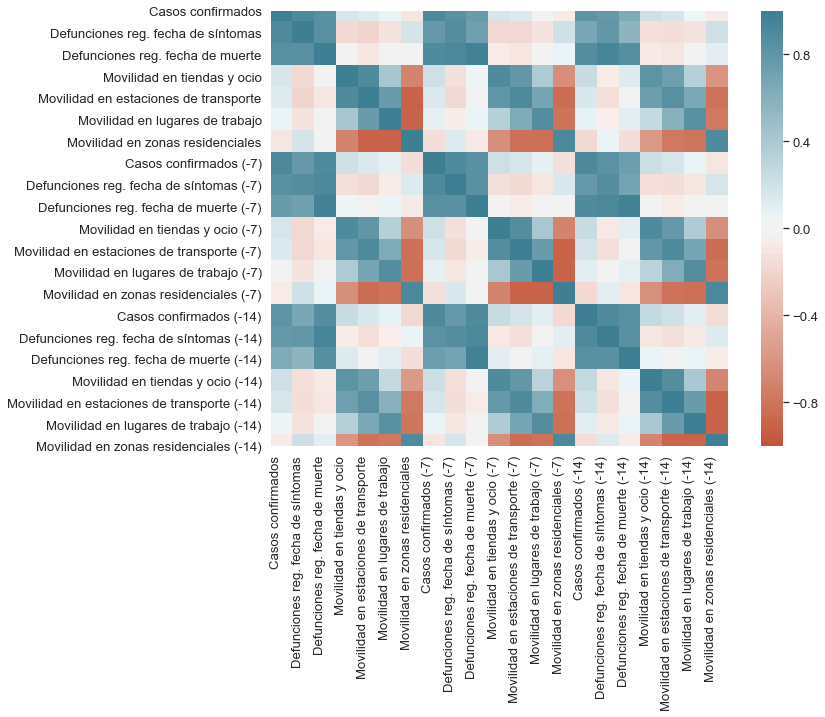

In [16]:
#

f, ax = plt.subplots(figsize=(12, 8))

ax = sns.heatmap( Corr, vmin = -1, vmax = 1, center = 0,
    cmap = sns.diverging_palette(20, 220, n = 200), #(10, 150, n = 10),
    square = True) #, annot = True)

ax.set_xticklabels( ax.get_xticklabels(), rotation = 90,
    horizontalalignment='right')

sns.set(font_scale = 1.5)

plt.show()

## Pruebas de Raíces Unitarias -- ADF

In [66]:
# Seleccionamos columnas sin NaN's y en una fecha posterior al los últimos días de marzo:

DF = Datos[(Datos['Fecha'] > '2020-03-20')].dropna()

# Calculamos valores en logaritmos

DF['LConfirmados'] = np.log(DF['Confirmados'])

DF['LDefunciones_Sint'] = np.log(DF['Defunciones_Sint'])

DF['LDefunciones_Muer'] = np.log(DF['Defunciones_Muer'])

#DF['LDefunciones'] = np.log(DF['Defunciones'])

#DF['LResidential'] = np.log(DF['Residential'])

#DF['LRecreation'] = np.log(DF['Recreation'])

# Calculamos valores en diferencias logaritmicas

DF['DLConfirmados'] = DF['LConfirmados'].diff(7)

DF['DLDefunciones_Sint'] = DF['LDefunciones_Sint'].diff(7)

DF['DLDefunciones_Muer'] = DF['LDefunciones_Muer'].diff(7)

#DF['DLDefunciones'] = DF['LDefunciones'].diff(7)

DF['DResidential'] = DF['Residential'].diff(7)

DF['DRecreation'] = DF['Recreation'].diff(7)

DF = DF.dropna()

DF.head()

,Fecha,Confirmados,Defunciones_Sint,Defunciones_Muer,Residential,Recreation,LConfirmados,LDefunciones_Sint,LDefunciones_Muer,DLConfirmados,DLDefunciones_Sint,DLDefunciones_Muer,DResidential,DRecreation
88,2020-03-29,290.0,62.0,9.0,11.0,-45.0,5.669881,4.127134,2.197225,0.516589,0.831298,1.504077,3.0,-8.0
89,2020-03-30,418.0,75.0,12.0,15.0,-35.0,6.035481,4.317488,2.484907,0.502092,0.556288,2.484907,3.0,-4.0
90,2020-03-31,325.0,69.0,22.0,16.0,-35.0,5.783825,4.234107,3.091042,0.480520,0.707746,2.397895,2.0,0.0
91,2020-04-01,513.0,102.0,20.0,18.0,-37.0,6.240276,4.624973,2.995732,0.776444,0.863773,2.302585,2.0,0.0
92,2020-04-02,469.0,102.0,27.0,19.0,-47.0,6.150603,4.624973,3.295837,0.498114,0.693147,1.216395,3.0,-10.0


In [71]:
# Confirmados

result = adfuller(DF['DLConfirmados'], 
                  regression = 'c', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.208874
p-value: 0.937456
Use lags: 17
Obs.: 340
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [72]:
# Defunciones_Sint

result = adfuller(DF['DLDefunciones_Sint'], 
                  regression = 'c', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.181258
p-value: 0.998867
Use lags: 14
Obs.: 343
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [73]:
# Defunciones_Muer

result = adfuller(DF['DLDefunciones_Muer'], 
                  regression = 'ct', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.395547
p-value: 0.051986
Use lags: 17
Obs.: 340
Critical Values:
	1%: -3.986
	5%: -3.423
	10%: -3.135


In [75]:
# Residential

result = adfuller(DF['DResidential'], 
                  regression = 'ct', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.051597
p-value: 0.000002
Use lags: 14
Obs.: 343
Critical Values:
	1%: -3.985
	5%: -3.423
	10%: -3.135


## Granger causality

In [57]:
Data = DF[['DLConfirmados', 'DLResidential']] 

grangercausalitytests(Data, [15], addconst = True, verbose = True)


Granger Causality
number of lags (no zero) 15
ssr based F test:         F=0.8905  , p=0.5755  , df_denom=234, df_num=15
ssr based chi2 test:   chi2=15.1266 , p=0.4423  , df=15
likelihood ratio test: chi2=14.7106 , p=0.4725  , df=15
parameter F test:         F=0.8905  , p=0.5755  , df_denom=234, df_num=15


{15: ({'ssr_ftest': (0.8904713880913613, 0.5755307844822487, 234.0, 15),
   'ssr_chi2test': (15.126597297705816, 0.44233719698993224, 15),
   'lrtest': (14.710629175040367, 0.4724549815034105, 15),
   'params_ftest': (0.8904713880913618, 0.5755307844822487, 234.0, 15.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [20]:
# Seleccionamos columnas sin NaN's y en una fecha posterior al los últimos días de marzo:

DF_MA = Datos[(Datos['Fecha'] > '2020-03-20')].dropna()

# Calculamos valores en logaritmos

DF_MA['LConfirmados'] = np.log(DF_MA['Confirmados'].rolling(window = 7).mean())

DF_MA['LDefunciones_Sint'] = np.log(DF_MA['Defunciones_Sint'].rolling(window = 7).mean())

DF_MA['LDefunciones_Muer'] = np.log(DF_MA['Defunciones_Muer'].rolling(window = 7).mean())

DF_MA['LDefunciones'] = np.log(DF_MA['Defunciones'].rolling(window = 7).mean())

DF_MA['LResidential'] = np.log(DF_MA['Residential'].rolling(window = 7).mean())

# Calculamos valores en diferencias logaritmicas

DF_MA['DLConfirmados'] = DF_MA['LConfirmados'].diff(1)

DF_MA['DLDefunciones_Sint'] = DF_MA['LDefunciones_Sint'].diff(1)

DF_MA['DLDefunciones_Muer'] = DF_MA['LDefunciones_Muer'].diff(1)

DF_MA['DLDefunciones'] = DF_MA['LDefunciones'].diff(1)

DF_MA['DLResidential'] = DF_MA['LResidential'].diff(1)

DF_MA = DF_MA.dropna()

DF_MA.head()

,Fecha,Confirmados,Defunciones_Sint,Defunciones_Muer,Defunciones,Defunciones_Reg,Residential,LConfirmados,LDefunciones_Sint,LDefunciones_Muer,LDefunciones,LResidential,DLConfirmados,DLDefunciones_Sint,DLDefunciones_Muer,DLDefunciones,DLResidential
88,2020-03-29,290.0,62.0,9.0,1954.0,1029.0,11.0,5.588853,3.874173,1.860752,7.571621,2.639057,0.064539,0.109656,0.169076,0.004940,0.031091
89,2020-03-30,418.0,75.0,12.0,1983.0,2358.0,15.0,5.673323,3.964886,2.079442,7.573531,2.669210,0.084471,0.090714,0.218689,0.001911,0.030153
90,2020-03-31,325.0,69.0,22.0,1874.0,1970.0,16.0,5.732416,4.055505,2.384823,7.570149,2.688819,0.059093,0.090618,0.305382,-0.003383,0.019608
91,2020-04-01,513.0,102.0,20.0,1956.0,2005.0,18.0,5.853023,4.191817,2.597385,7.574192,2.708050,0.120607,0.136312,0.212561,0.004043,0.019231
92,2020-04-02,469.0,102.0,27.0,1901.0,1889.0,19.0,5.925783,4.296313,2.781478,7.566755,2.736221,0.072759,0.104496,0.184093,-0.007437,0.028171


In [29]:
# Confirmados

result = adfuller(DF_MA['DLConfirmados'], 
                  regression = 'c', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.304511
p-value: 0.014678
Use lags: 16
Obs.: 263
Critical Values:
	1%: -3.455
	5%: -2.873
	10%: -2.573


In [34]:
# Defunciones_Sint

result = adfuller(DF_MA['DLDefunciones_Sint'], 
                  regression = 'c', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.594402
p-value: 0.005869
Use lags: 16
Obs.: 263
Critical Values:
	1%: -3.455
	5%: -2.873
	10%: -2.573


In [32]:
# Defunciones_Muer

result = adfuller(DF_MA['DLDefunciones_Muer'], 
                  regression = 'ct', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.115034
p-value: 0.005994
Use lags: 16
Obs.: 263
Critical Values:
	1%: -3.994
	5%: -3.427
	10%: -3.137


In [38]:
# Defunciones

result = adfuller(DF_MA['DLDefunciones'], 
                  regression = 'ct', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.692488
p-value: 0.754157
Use lags: 14
Obs.: 265
Critical Values:
	1%: -3.993
	5%: -3.427
	10%: -3.137


In [41]:
# Residential

result = adfuller(DF_MA['DLResidential'], 
                  regression = 'ct', # “c” : constant only; “ct” : constant and trend; “nc” : no constant, no trend
                  autolag='AIC',)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Use lags: %i' % result[2])
print('Obs.: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.194162
p-value: 0.000000
Use lags: 6
Obs.: 273
Critical Values:
	1%: -3.992
	5%: -3.427
	10%: -3.137
